In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit

## Generalized Linear Models

**Linear Models**: Expected value is additive ("linear") combination of parameters

**Generalized LInear Models**: Expected value is some function of an additive combination of parameters

Uniform changes in predictor not uniform changes in prediction

All predictor variables interact, moderate one another

Influences predictions & uncertainty of predictions

Ceiling and floor effects, everything moderating everything else

## Confounded Admissions

Adding the confound of 'ability' (qualities of cand. that are difficult to measure that influence department and admission)

In [59]:
## Generative Sim

N = 2000
G = np.random.binomial(1,0.5,size=N)
U = np.random.binomial(1,0.1,size=N) #Sim high peeps

#Gender 0 tends to apply to dept 0, 1 to 1
D = np.random.binomial(1,[1*u if g==0 else 0.75 for g,u in zip(G,U)])
GD0 = np.histogram2d(G[U==0], D[U==0], bins=(2,2))[0]
GD1 = np.histogram2d(G[U==1], D[U==1], bins=(2,2))[0]

#Array of acceptance rates [dept,gender]

p_u0 = np.array([[0.1,0.1],[0.1,0.3]])
p_u1 = np.array([[0.3,0.5],[0.3,0.5]])
print('GD, U == 0')
print(GD0)
print('GD, U == 1')
print(GD1)
#print('Acceptance Rates')
#print('Gender 0: '+ str(GA[0,1]/np.sum(GA[0])))
#print('Gender 1: '+ str(GA[1,1]/np.sum(GA[1])))

p_u = np.array([p_u0,p_u1])
#p   = [p_u[[U[i]]][D[i],G[i]] for i in range(N)] 
# p_u = [ability,department,gender]
p    = np.array([p_u[U[i],D[i],G[i]] for i in range(N)])
#p_u[:,:,1]

A = np.random.binomial(1,p)

GD, U == 0
[[931.   0.]
 [215. 647.]]
GD, U == 1
[[ 0. 95.]
 [31. 81.]]


In [62]:
with pm.Model() as tot_sim:
    a = pm.Normal('a',0,1,shape=2)
    p =  pm.Deterministic("p", pm.invlogit(a[G]))
    likelihood = pm.Bernoulli('A',p,observed=A)
    tot_sim_trace = pm.sample()
    

G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [63]:
with pm.Model() as direct_sim: #Confounded
    a = pm.Normal('a',0,1,shape=(2,2))
    p =  pm.Deterministic("p", pm.invlogit(a[G,D]))
    likelihood = pm.Bernoulli('A',p,observed=A)
    dir_sim_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [65]:
az.summary(tot_sim_trace)[:2]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-1.883,0.089,-2.050,-1.718,0.002,0.001,3408.0,2901.0,1.0
a[1],-1.026,0.071,-1.152,-0.880,0.001,0.001,3878.0,2851.0,1.0


In [66]:
#In log odds
az.summary(dir_sim_trace)[:4]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[0, 0]",-2.014,0.102,-2.201,-1.823,0.001,0.001,6894.0,3420.0,1.0
"a[0, 1]",-0.939,0.224,-1.347,-0.513,0.003,0.002,7118.0,2940.0,1.0
"a[1, 0]",-1.785,0.184,-2.129,-1.448,0.002,0.002,6408.0,2809.0,1.0
"a[1, 1]",-0.818,0.081,-0.970,-0.665,0.001,0.001,8119.0,3129.0,1.0


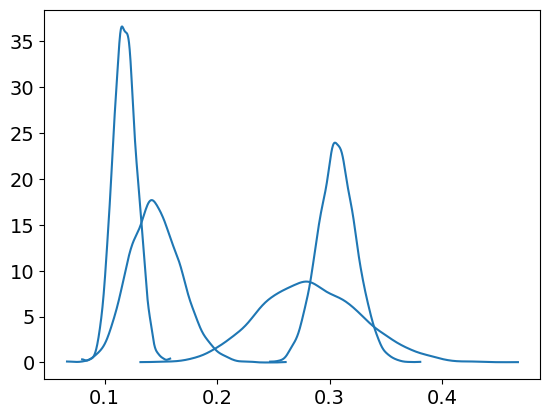

In [80]:
for i in range(2):
    for j in range(2):
        az.plot_kde(expit(dir_sim_trace.posterior.a.values[:,:,i,j]))
        
#Probability distribution of probabilities,
#for each deptartment:gender pair.
#Exceptional individuals of gender 1 don't apply to dept1
# So admission of applicants appear discriminated
#D2 has discrimination, but because ofthe ability, it has a 
# masking effect

## Collider Bias

Stratifying by D opens non-causal path through u

Can estimate total causal effect of G, but isn't what we want

Cannot estimate direct effect of D or G. 

Intuitive explantion:

High ability G1s apply to discriminatory department anyway

G1s in that department are higher ability on average than G2s

High ability compensates for discrimination => masks evidence